## POS tagging using modified Viterbi

###### We accomplished the following in this assignment:
1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import requests
import random
import re, pprint
import time

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split 
from nltk.tokenize import word_tokenize 
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\v-jysha\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

Splitting the Treebank dataset into train and validation sets. 
As suggested, Sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

In [3]:
train_set , test_set = train_test_split(nltk_data , train_size = .95, test_size = .05 , random_state = 70)


In [4]:
#total length of data before splitting
print(len(nltk_data))
#total length of the train set after splitting the data
print(len(train_set))
#total length of the test set after splitting the data
print(len(test_set))
#First item in the training set
print(train_set[:1])

3914
3718
196
[[('Temple', 'NOUN'), (',', '.'), ('however', 'ADV'), (',', '.'), ('harshly', 'ADV'), ('criticized', 'VERB'), ('Sea', 'NOUN'), ('Containers', 'NOUN'), ("'", 'PRT'), ('plan', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('characterizing', 'VERB'), ('it', 'PRON'), ('as', 'ADP'), ('a', 'DET'), ('``', '.'), ('highly', 'ADV'), ('conditional', 'ADJ'), ('device', 'NOUN'), ('designed', 'VERB'), ('*', 'X'), ('*-2', 'X'), ('to', 'PRT'), ('entrench', 'VERB'), ('management', 'NOUN'), (',', '.'), ('confuse', 'VERB'), ('shareholders', 'NOUN'), ('and', 'CONJ'), ('prevent', 'VERB'), ('them', 'PRON'), ('from', 'ADP'), ('*-3', 'X'), ('accepting', 'VERB'), ('our', 'PRON'), ('superior', 'ADJ'), ('cash', 'NOUN'), ('offer', 'NOUN'), ('.', '.'), ("''", '.')]]


In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95870

In [6]:
# Getting the tokens  
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Temple',
 ',',
 'however',
 ',',
 'harshly',
 'criticized',
 'Sea',
 'Containers',
 "'",
 'plan']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12088


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
#Tags
print(T)

{'ADV', 'ADJ', '.', 'PRT', 'PRON', 'VERB', 'X', 'DET', 'NOUN', 'ADP', 'NUM', 'CONJ'}


### Emission Probabilities

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities


In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [14]:
tags_df.loc['.', :]

ADV     0.053345
ADJ     0.043197
.       0.091783
PRT     0.002515
PRON    0.065469
VERB    0.089807
X       0.027211
DET     0.173507
NOUN    0.222452
ADP     0.091334
NUM     0.081275
CONJ    0.058015
Name: ., dtype: float32

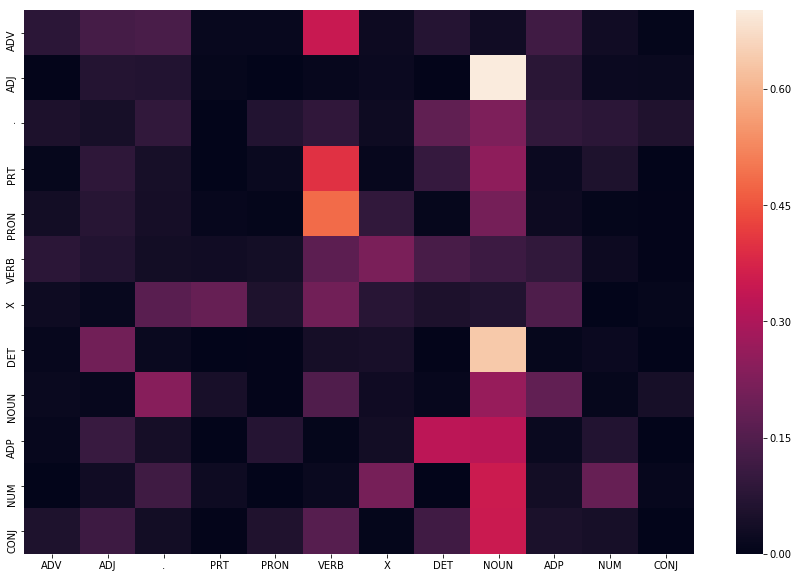

In [15]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(15, 10))
sns.heatmap(tags_df)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [16]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



##### Testing Vanilla Viterbi Algorithm 

In [17]:
# Running on entire test dataset would take more than 3-4hrs so instead evaluate on few sentences. 

random.seed(1234)
# choose random 10 sentence
rndom = [random.randint(1,len(test_set)) for x in range(10)]
# list of sentence
test_run = [test_set[i] for i in rndom]
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('So', 'ADP'),
  ('far', 'ADV'),
  (',', '.'),
  ('Mrs.', 'NOUN'),
  ('Hills', 'NOUN'),
  ('has', 'VERB'),
  ("n't", 'ADV'),
  ('deemed', 'VERB'),
  ('any', 'DET'),
  ('cases', 'NOUN'),
  ('bad', 'ADJ'),
  ('enough', 'ADV'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('merit', 'VERB'),
  ('an', 'DET'),
  ('accelerated', 'VERB'),
  ('investigation', 'NOUN'),
  ('under', 'ADP'),
  ('the', 'DET'),
  ('so-called', 'ADJ'),
  ('special', 'ADJ'),
  ('301', 'NUM'),
  ('provision', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('act', 'NOUN'),
  ('.', '.')],
 [('Despite', 'ADP'),
  ('the', 'DET'),
  ('strong', 'ADJ'),
  ('evidence', 'NOUN'),
  ('against', 'ADP'),
  ('Mrs.', 'NOUN'),
  ('Yeargin', 'NOUN'),
  (',', '.'),
  ('popular', 'ADJ'),
  ('sentiment', 'NOUN'),
  ('*ICH*-1', 'X'),
  ('was', 'VERB'),
  ('so', 'ADV'),
  ('strong', 'ADJ'),
  ('*ICH*-3', 'X'),
  ('in', 'ADP'),
  ('her', 'PRON'),
  ('favor', 'NOUN'),
  (',', '.'),
  ('Mrs.', 'NOUN'),
  ('Ward', 'NOUN'),
  ('says', 'VERB'),
  ('0', 'X'

In [18]:
#function to find out the Accuracy
def Check_accuracy(tagged_seq , tagged_word_tag):
    check = [i for i, j in zip(tagged_seq, tagged_word_tag) if i == j] 
    accuracy = len(check)/len(tagged_seq)
    return accuracy

In [19]:
#function to find out the incorrect tagged cases
def Find_unmatched_tagged_cases(tagged_seq , tagged_word_tag):
    unmatched_tagged_cases = [[tagged_word_tag[i-1],j] for i, j in enumerate(zip(tagged_seq, tagged_word_tag)) if j[0]!=j[1]]
    return unmatched_tagged_cases  

In [20]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()

print("Time taken in seconds: ", end-start)

accuracy_viterbi = Check_accuracy(tagged_seq , test_run_base)
print("Vanilla Viterbi Algorithm Accuracy is: ",accuracy_viterbi)

Time taken in seconds:  49.140602350234985
Vanilla Viterbi Algorithm Accuracy is:  0.9027237354085603


In [21]:
print(tagged_seq[:20])

[('So', 'ADV'), ('far', 'ADV'), (',', '.'), ('Mrs.', 'NOUN'), ('Hills', 'NOUN'), ('has', 'VERB'), ("n't", 'ADV'), ('deemed', 'ADV'), ('any', 'DET'), ('cases', 'NOUN'), ('bad', 'ADJ'), ('enough', 'ADJ'), ('*-1', 'X'), ('to', 'PRT'), ('merit', 'NOUN'), ('an', 'DET'), ('accelerated', 'ADJ'), ('investigation', 'NOUN'), ('under', 'ADP'), ('the', 'DET')]


In [22]:
unmatched = Find_unmatched_tagged_cases(tagged_seq , test_run_base)
unmatched[:10]

[[('.', '.'), (('So', 'ADV'), ('So', 'ADP'))],
 [("n't", 'ADV'), (('deemed', 'ADV'), ('deemed', 'VERB'))],
 [('bad', 'ADJ'), (('enough', 'ADJ'), ('enough', 'ADV'))],
 [('to', 'PRT'), (('merit', 'NOUN'), ('merit', 'VERB'))],
 [('an', 'DET'), (('accelerated', 'ADJ'), ('accelerated', 'VERB'))],
 [('special', 'ADJ'), (('301', 'ADV'), ('301', 'NUM'))],
 [('her', 'PRON'), (('favor', 'VERB'), ('favor', 'NOUN'))],
 [(',', '.'), (('that', 'DET'), ('that', 'ADP'))],
 [('of', 'ADP'), (('two-letter', 'ADV'), ('two-letter', 'ADJ'))],
 [('two-letter', 'ADJ'), (('consonant', 'ADV'), ('consonant', 'ADJ'))]]

In [23]:
tagged_words=[tup for ls in test_set for tup in ls]
vocabulary_validation=set([t[0] for t in tagged_words])
print(len(V),' ',len(vocabulary_validation))

Unknownwords=list(vocabulary_validation-V)
print("Total Unknown words: {}".format(len(Unknownwords)))


12088   1820
Total Unknown words: 320


### Solve the problem of unknown words

In [24]:
#all the unknown words
Unknownwords

['livelihood',
 'Four',
 'Dale',
 '1.17',
 'drop-in',
 '9.3',
 'Heatherington',
 'heavy-duty',
 'pride',
 'English-speaking',
 'sweaty',
 'favors',
 'quote',
 'diagnosed',
 'Henderson',
 'corn-buying',
 'consonant',
 'rebuilding',
 'stacking',
 'unsympathetic',
 'muzzling',
 'odd-year',
 'weight',
 'transplantation',
 'juvenile',
 'rendering',
 'Abbey',
 'uncanny',
 'Metal',
 'Trans',
 'sewer',
 'APPEARS',
 'accompany',
 'disagreeable',
 '51-year-old',
 'sketching',
 'dusty',
 'Hayes',
 'Scotia',
 'bell-ringing',
 'caustic',
 'three-quarters',
 'queuing',
 'deck',
 'Andean',
 'sticky',
 'Kathryn',
 'injuring',
 'retiring',
 '59.6',
 'bang',
 'Commodities',
 'restricts',
 '50-state',
 'recommendation',
 'Areas',
 '858,000',
 'unlikely',
 'hoopla',
 'ambassadors',
 '18.3',
 'skirmishes',
 'exclusion',
 'fluent',
 'deliberating',
 'drastic',
 'pain',
 'softer',
 'mentioned',
 'approached',
 'Pa',
 'upper',
 'Youths',
 'Except',
 'philosophy',
 'published',
 '4.875',
 'engines',
 'designat

##### Viterbi Modification-Method I

In [25]:
def Viterbi_update1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    tag_prob = []
    total_tag = len([tag for word,tag in train_tagged_words])
    for t in T:
        each_tag = [tag for word,tag in train_tagged_words if tag==t]
        tag_prob.append((t,len(each_tag)/total_tag))
        
    for key, word in enumerate(words):
        #initialise the variables for prob and transition prob
        p = [] 
        p_transition =[]       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p=word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability=emission_p*transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_pos=[pair[1] for pair in tag_prob if pair[0]==tag]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p=tag_pos[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax=max(p)
        state_max=T[p.index(pmax)]        
      
        # Use the weighted transition probability if probability is zero(unknown word)
        if(pmax==0):
            pmax=max(p_transition)
            state_max=T[p_transition.index(pmax)]                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [26]:
start = time.time()
tagged_seq_upd1 = Viterbi_update1(test_tagged_words)
end = time.time()

print("Total time taken in seconds: ", end-start)

accuracy_update1 = Check_accuracy(tagged_seq_upd1 , test_run_base)
print("Accuracy after 1st update is: ",accuracy_update1)

Total time taken in seconds:  48.204514503479004
Accuracy after 1st update is:  0.9221789883268483


In [27]:
tagged_seq_upd1[:20]

[('So', 'ADV'),
 ('far', 'ADV'),
 (',', '.'),
 ('Mrs.', 'NOUN'),
 ('Hills', 'NOUN'),
 ('has', 'VERB'),
 ("n't", 'ADV'),
 ('deemed', 'VERB'),
 ('any', 'DET'),
 ('cases', 'NOUN'),
 ('bad', 'ADJ'),
 ('enough', 'ADJ'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('merit', 'NOUN'),
 ('an', 'DET'),
 ('accelerated', 'ADJ'),
 ('investigation', 'NOUN'),
 ('under', 'ADP'),
 ('the', 'DET')]

In [28]:
unmatched = Find_unmatched_tagged_cases(tagged_seq_upd1 , test_run_base)
unmatched[:10]

[[('.', '.'), (('So', 'ADV'), ('So', 'ADP'))],
 [('bad', 'ADJ'), (('enough', 'ADJ'), ('enough', 'ADV'))],
 [('to', 'PRT'), (('merit', 'NOUN'), ('merit', 'VERB'))],
 [('an', 'DET'), (('accelerated', 'ADJ'), ('accelerated', 'VERB'))],
 [('special', 'ADJ'), (('301', 'NOUN'), ('301', 'NUM'))],
 [('her', 'PRON'), (('favor', 'VERB'), ('favor', 'NOUN'))],
 [(',', '.'), (('that', 'DET'), ('that', 'ADP'))],
 [('of', 'ADP'), (('two-letter', 'NOUN'), ('two-letter', 'ADJ'))],
 [('two-letter', 'ADJ'), (('consonant', 'NOUN'), ('consonant', 'ADJ'))],
 [('consonant', 'ADJ'), (('sounds', 'VERB'), ('sounds', 'NOUN'))]]

##### Viterbi Modification-Method II

In [29]:
patterns = [
    (r'.*ing$', 'VERB'),              
    (r'.*ed$', 'VERB'),               
    (r'.*es$', 'VERB'),               
    (r'.*\'s$', 'NOUN'),              
    (r'.*s$', 'NOUN'),                
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), 
    (r'.*', 'NOUN')                    
]
rule_based_tagger = nltk.RegexpTagger(patterns)
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

In [30]:
#function that uses POS Tagger 
#def Viterbi_update2(words, unknown_words=Unknownwords, train_bag = train_tagged_words):
def Viterbi_update2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    tag_prob = []
    total_tag= len([tag for word,tag in train_tagged_words])
    for t in T:
        each_tag= [tag for word,tag in train_tagged_words if tag==t]
        tag_prob.append((t,len(each_tag)/total_tag))       
    
    for key, word in enumerate(words):
        #initialise the variables for prob and transition prob
        p = [] 
        p_transition =[] 
        for tag in T:
            if key== 0:
                transition_p=tags_df.loc['.', tag]
            else:
                transition_p=tags_df.loc[state[-1], tag]
                
            emission_p=word_given_tag(words[key], tag)[0]/word_given_tag(words[key],tag)[1] 
            state_probability=emission_p*transition_p    
            p.append(state_probability)            
            # find POS tag occurance probability
            tag_pos=[pair[1] for pair in tag_prob if pair[0]==tag]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p=tag_pos[0]*transition_p
            p_transition.append(transition_p)
            
        pmax=max(p)
        state_max = lexicon_tagger.tag([word])[0][1]         
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = lexicon_tagger.tag([word])[0][1] # assign based on rule based tagger            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max=='NOUN':
                pmax=max(p_transition)
                state_max=T[p_transition.index(pmax)]                 
        else:
             if state_max!='X':
                state_max = T[p.index(pmax)]         
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# tagging
start = time.time()
tagged_seq_upd2 = Viterbi_update2(test_tagged_words)
end = time.time()

print("Total time taken in seconds: ", end-start)

accuracy_update2 = Check_accuracy(tagged_seq_upd2 , test_run_base)
print("Accuracy after 2nd update is: ", accuracy_update2)

Total time taken in seconds:  48.76544666290283
Accuracy after 2nd update is:  0.9260700389105059


In [32]:
tagged_seq_upd2[:20]

[('So', 'ADV'),
 ('far', 'ADV'),
 (',', '.'),
 ('Mrs.', 'NOUN'),
 ('Hills', 'NOUN'),
 ('has', 'VERB'),
 ("n't", 'ADV'),
 ('deemed', 'VERB'),
 ('any', 'DET'),
 ('cases', 'NOUN'),
 ('bad', 'ADJ'),
 ('enough', 'ADJ'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('merit', 'NOUN'),
 ('an', 'DET'),
 ('accelerated', 'ADJ'),
 ('investigation', 'NOUN'),
 ('under', 'ADP'),
 ('the', 'DET')]

In [33]:
unmatched = Find_unmatched_tagged_cases(tagged_seq_upd2 , test_run_base)
unmatched[:10]

[[('.', '.'), (('So', 'ADV'), ('So', 'ADP'))],
 [('bad', 'ADJ'), (('enough', 'ADJ'), ('enough', 'ADV'))],
 [('to', 'PRT'), (('merit', 'NOUN'), ('merit', 'VERB'))],
 [('an', 'DET'), (('accelerated', 'ADJ'), ('accelerated', 'VERB'))],
 [('her', 'PRON'), (('favor', 'VERB'), ('favor', 'NOUN'))],
 [(',', '.'), (('that', 'DET'), ('that', 'ADP'))],
 [('of', 'ADP'), (('two-letter', 'NOUN'), ('two-letter', 'ADJ'))],
 [('two-letter', 'ADJ'), (('consonant', 'NOUN'), ('consonant', 'ADJ'))],
 [('consonant', 'ADJ'), (('sounds', 'VERB'), ('sounds', 'NOUN'))],
 [('same', 'ADJ'), (('sounds', 'VERB'), ('sounds', 'NOUN'))]]

#### Evaluating tagging accuracy

In [34]:
print("Vanilla Viterbi Algorithm Accuracy is: ",accuracy_viterbi)

Vanilla Viterbi Algorithm Accuracy is:  0.9027237354085603


In [35]:
print("Accuracy after 1st update is : ",accuracy_update1)

Accuracy after 1st update is :  0.9221789883268483


In [36]:
print("Accuracy after 2nd update is: ", accuracy_update2)

Accuracy after 2nd update is:  0.9260700389105059


###### Evaluating tagging on sample 'Test_sentences.txt' file

In [37]:
file = open('Test_sentences.txt')
textfile = file.read()
sample_sent = textfile.splitlines()
file.close()

In [38]:
# list of untagged words
sample_test_words = [word for sent in sample_sent for word in sent.split()]

In [39]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()

print("Time taken in seconds: ", end-start)

Time taken in seconds:  32.405014991760254


In [40]:
# tagging the test sentences using 1st update
start = time.time()
sample_tagged_seq1 = Viterbi_update1(sample_test_words)
end = time.time()

print("Time taken in seconds: ", end-start)

Time taken in seconds:  31.338361263275146


In [41]:
# tagging the test sentences using 2nd update
start = time.time()
sample_tagged_seq2 = Viterbi_update2(sample_test_words)
end = time.time()

print("Time taken in seconds: ", end-start)

Time taken in seconds:  33.03256940841675


In [42]:
#finding the unmatching between viterbi and viterbi 1st update 
unmatched = Find_unmatched_tagged_cases(sample_tagged_seq , sample_tagged_seq1)
unmatched

[[('Satellite.', 'NOUN'), (('Android', 'ADV'), ('Android', 'NOUN'))],
 [('by', 'ADP'), (('Google.', 'ADV'), ('Google.', 'NOUN'))],
 [('Google.', 'NOUN'), (('Android', 'ADV'), ('Android', 'NOUN'))],
 [('best-selling', 'ADJ'), (('OS', 'ADV'), ('OS', 'NOUN'))],
 [('OS', 'NOUN'), (('worldwide', 'ADV'), ('worldwide', 'NOUN'))],
 [('on', 'ADP'), (('smartphones', 'ADV'), ('smartphones', 'NOUN'))],
 [('since', 'ADP'), (('2011', 'ADV'), ('2011', 'NOUN'))],
 [('since', 'ADP'), (('2013.', 'ADV'), ('2013.', 'NOUN'))],
 [('2013.', 'NOUN'), (('Google', 'ADV'), ('Google', 'NOUN'))],
 [('and', 'CONJ'), (('Twitter', 'ADV'), ('Twitter', 'NOUN'))],
 [('in', 'ADP'), (('2015', 'ADV'), ('2015', 'NOUN'))],
 [('gave', 'VERB'), (('Google', 'ADV'), ('Google', 'NOUN'))],
 [('to', 'PRT'), (("Twitter's", 'ADV'), ("Twitter's", 'NOUN'))],
 [("Twitter's", 'NOUN'), (('firehose.', 'ADV'), ('firehose.', 'NOUN'))],
 [('firehose.', 'NOUN'), (('Twitter', 'ADV'), ('Twitter', 'NOUN'))],
 [('an', 'DET'), (('online', 'ADV'), (

In [43]:
#finding the unmatching between viterbi 1st update and viterbi 2nd update 
unmatched = Find_unmatched_tagged_cases(sample_tagged_seq1 , sample_tagged_seq2)
unmatched

[[('on', 'ADP'), (('smartphones', 'NOUN'), ('smartphones', 'VERB'))],
 [('since', 'ADP'), (('2011', 'NOUN'), ('2011', 'NUM'))],
 [('in', 'ADP'), (('2015', 'NOUN'), ('2015', 'NUM'))],
 [('with', 'ADP'), (('messages', 'NOUN'), ('messages', 'VERB'))],
 [('a', 'DET'), (('domineering', 'NOUN'), ('domineering', 'VERB'))],
 [('The', 'DET'), (('2018', 'NOUN'), ('2018', 'NUM'))],
 [('tournament', 'NOUN'), (('contested', 'NOUN'), ('contested', 'VERB'))],
 [('and', 'CONJ'), (('arriving', 'NOUN'), ('arriving', 'VERB'))],
 [('NASA', 'NOUN'), (('invited', 'NOUN'), ('invited', 'VERB'))]]

On the test sentence file , we got the following :

1. Cases which are correctly POS tagged by Viterbi_update1:

Android AS 'NOUN'                                                                                                        
Google AS 'NOUN'                                                                                                         
worldwide as 'NOUN'                                                                                                       
OS as 'NOUN'

2. Cases which are correctly POS tagged by Viterbi_update2:

2011 as 'NUM'                                                                                                                 
2015 as 'NUM'  
contested as 'VERB'                                                                                                       
invited as 'VERB'                                                                                                             
arriving as 'VERB'                                                                                                           
    

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Vanilla Viterbi Algorithm Accuracy is:  90.27%                                                                
Accuracy after first update is :  92.21%                                                                                
Accuracy after second update is:  92.61%

And clearly the second update shows the increased accuracy. 

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

The following are few cases were incorrectly tagged which got corrected by modified Viterbi Algorithm:

deemed correctly tagged as VERB                                                                                         
301 correctly tagged as NUM                                                                                                    
two-letter correctly tagged as NOUN                                                                                            
consonant correctly tagged as NOUN                                                                                            
exclusion correctly tagged as NOUN                                                                                            
Handelsbanken correctly tagged as NOUN                                                                                         
modification correctly tagged as NOUN                                                                                         
C'mon correctly tagged as NOUN                                                                                                